In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import salishsea_tools

import datetime
import os

import nowcast

from matplotlib import gridspec

from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

%matplotlib inline

import scipy.io as sio

In [2]:
coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

In [3]:
# Copyright 2013-2016 The Salish Sea MEOPAR contributors
# and The University of British Columbia

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A collection of functions for use by multiple figure modules in the
:kbd:`nowcast.figures` namespaces.

.. note::
    These functions are intended for use *only* by :kbd:`nowcast.figures`
    modules.
    If you find that you want to use one of these functions outside of those
    namespaces please talk to the group about refactoring the function into
    the :ref:`SalishSeaToolsPackage`.
"""
import io
import os

import matplotlib.image
from matplotlib import patches
from matplotlib.backends import backend_agg as backend
from matplotlib.figure import Figure
import numpy as np

from salishsea_tools import stormtools
from salishsea_tools.places import PLACES

import nowcast.figures.website_theme


def plot_map(
    ax,
    coastline,
    lat_range=(47.5, 50.7),
    lon_range=(-126, -122),
    land_patch_min_area=1e-3,
    theme=nowcast.figures.website_theme,
):
    """Plot a map of the Salish Sea region, including the options to add a
    coastline, colour of the land, and colour of the domain.

    The map produced by this function is intended for use as the background for
    figures on which model results are plotted.
    It is rasterized to minimize the file size of the resulting rendered
    figure image, an important consideration for web site figure images.

    :arg ax: Axes object to plot the map on.
    :type ax: :py:class:`matplotlib.axes.Axes`

    :arg dict coastline: Pacific Northwest Coastline from matlab :kbd:`.mat`
                         file.

    :arg 2-tuple lat_range: Latitude range to be plotted.

    :arg 2-tuple lon_range: Longitude range to be plotted.

    :arg float land_patch_min_area: Minimum area of land patch to be plotted.

    :arg theme: Module-like object that defines the style elements for the
                figure. See :py:mod:`nowcast.figures.website_theme` for an
                example.
    """
    mapfig = _make_background_map(
        coastline, lat_range, lon_range, land_patch_min_area, theme)
    buffer_ = _render_png_buffer(mapfig)
    img = matplotlib.image.imread(buffer_, format='anything')
    ax.imshow(img, zorder=0, extent=[*lon_range, *lat_range])
    ax.set_xlim(lon_range)
    ax.set_ylim(lat_range)


def _make_background_map(
    coastline, lat_range, lon_range, land_patch_min_area, theme,
):
    fig = Figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    # Plot coastline
    coast_lat = coastline['ncst'][:, 1]
    coast_lon = coastline['ncst'][:, 0]
    ax.plot(coast_lon, coast_lat, '-k', rasterized=True, markersize=1)
    # Plot land patches
    mask = coastline['Area'][0] > land_patch_min_area
    kss = coastline['k'][:, 0][:-1][mask]
    kee = coastline['k'][:, 0][1:][mask]
    for ks, ke in zip(kss, kee):
        poly = list(zip(coast_lon[ks:ke-2], coast_lat[ks:ke-2]))
        ax.add_patch(
            patches.Polygon(
                poly, facecolor=theme.COLOURS['land'], rasterized=True))
    # Format the axes
    ax.set_frame_on(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.set_xlim(lon_range)
    ax.set_ylim(lat_range)
    fig.set_tight_layout({'pad': 0})
    return fig


def _render_png_buffer(fig):
    canvas = backend.FigureCanvasAgg(fig)
    buffer = io.BytesIO()
    canvas.print_figure(buffer, format='png')
    return buffer


def get_tides(stn_name, path='../../tidal_predictions/'):
    """Return the tidal predictions at the named tide gauge station station.

    :arg str stn_name: Name of the tide gauge station.

    :arg str path: Path to the directory containing the tidal prediction
                   .csv files to use.
                   Default value resolves to
                   :file:`SalishSeaNowcast/tidal_predications/
                   for calls elsewhere in the
                   :py:mod:`~SalishSeaNowcast.nowcast.figures` namespace.

    :returns: Tidal predictions object with columns time, pred_all, pred_8.
    :rtype: :py:class:`pandas.Dataframe`
    """
    fname = '{}_tidal_prediction_01-Jan-2015_01-Jan-2020.csv'.format(stn_name)
    ttide, _ = stormtools.load_tidal_predictions(os.path.join(path, fname))
    return ttide


def find_ssh_max(tide_gauge_stn, ssh_ts, ttide):
    """Find the maximum corrected sea surface height at a tide gauge station,
    and the date/time at which it occurrs.

    :arg str tide_gauge_stn: Name of tide gauge station.

    :arg ssh_ts: Sea surface height time series.
                 :py:attr:`ssh` attribute is a :py:class:`numpy.ndarray` of
                 sea surface height values.
                 :py:attr:`time` attribute is a :py:class:`numpy.ndarray` of
                 :py:class:`~datetime.datetime` object.
    :type ssh_ts: :py:class:`collections.namedtuple`

    :arg ttide: Tidal predictions data structure with :kbd:`time`,
                :kbd:`pred_all`, :kbd:`pred_8`, and :kbd:`pred_noshallow`
                columns.
    :type ttide: :py:class:`pandas.DataFrame`
    """
    ssh_corr = correct_model_ssh(*ssh_ts, ttide)
    max_ssh = np.max(ssh_corr) + PLACES[tide_gauge_stn]['mean sea lvl']
    max_ssh_time = ssh_ts.time[np.argmax(ssh_corr)]
    return max_ssh, max_ssh_time


## TODO: Move to stormtools module and/or merge w/ stormtools.correct_model()
## TODO: Perhaps refactor to accept a ssh_ts namedtuple
def correct_model_ssh(ssh_model, t_model, ttide):
    """Adjust model sea surface height by correcting for error due to using
    only 8 tidal constituents.

    Based on :py:func:`salishsea_tools.stormtools.correct_model`.
    Uses a tidal prediction with no shallow water minus a tidal prediction with
    8 constituents.

    :arg ssh_model: Sea surface height model results.
    :type ssh_model: :py:class:`numpy.ndarray`

    :arg t_model: Model :py:class:`~datetime.datetime` objects corresponding to
                  :kbd:`ssh_model`.
    :type t_model: :py:class:`numpy.ndarray`

    :arg ttide: Tidal predictions data structure with :kbd:`time`,
                :kbd:`pred_all`, :kbd:`pred_8`, and :kbd:`pred_noshallow`
                columns.
    :type ttide: :py:class:`pandas.DataFrame`

    :returns: Corrected model sea surface height.
    :rtype: :py:class:`numpy.ndarray`
    """
    difference = np.array(ttide[' pred_noshallow '] - ttide['pred_8'])
    corr = interp_to_model_time(t_model, difference, ttide.time)
    corr_model = ssh_model + corr
    return corr_model


## TODO: This should probably be in a salishsea_tools module.
def interp_to_model_time(t_model, values, t_values):
    """Interpolate a an array of values to model output times.

    Strategy: Convert times to seconds past a reference value and use those
    as the independent variable in interpolation.

    :arg t_model: Model output times as :py:class:`~datetime.datetime` objects.
    :type t_model: :py:class:`numpy.ndarray`

    :arg values: Values to be interpolated to model output times.
    :type values: :py:class:`numpy.ndarray`

    :arg t_values: Times corresponding to :kbd:`values` as
                   :py:class:`~datetime.datetime` objects.
    :type t_values: :py:class:`numpy.ndarray`

    :returns: Values interpolated to :kbd:`t_model` times.
    :rtype: :py:class:`numpy.ndarray`
    """
    epoch = t_model[0]
    t_values_wrt_epoch = np.array(
        [(t - epoch).total_seconds() for t in t_values])
    t_model_wrt_epoch = np.array(
        [(t - epoch).total_seconds() for t in t_model])
    return np.interp(
        t_model_wrt_epoch, t_values_wrt_epoch, values,
        left=np.NaN, right=np.NaN)


def plot_risk_level_marker(
    ax, tide_gauge_name, risk_level, marker, msize, alpha, theme,
):
    """Draw a storm surge risk level marker at tide gauge location.

    The axes is assumed to be using lon/lat scales.

    :arg ax: Axes object to draw the marker on.
    :type ax: :py:class:`matplotlib.axes.Axes`

    :arg str tide_gauge_name: Name of the tide gauge site at which to plot the
                              marker.

    :arg str risk_level: Storm surge risk level identifier,
                         perhaps from
                         :py:func:`salishsea_tools.stormtools.storm_surge_risk_level`:
                         :py:obj:`None` for no storm surge risk,
                         :kbd:`moderate risk` for water level between max tide
                         level and the half-way threshold,
                         and :kbd:`extreme risk` for water level above the
                         half-way threshold

    :arg str marker: Marker identifier from :py:mod:`matplotlib.markers`.

    :arg float msize: Marker size.

    :arg float alpha: Marker transparency.

    :arg theme: Module-like object that defines the style elements for the
                figure. See :py:mod:`nowcast.figures.website_theme` for an
                example.
    """
    ax.plot(
        *PLACES[tide_gauge_name]['lon lat'],
        marker=marker, markersize=msize, markeredgewidth=2, alpha=alpha,
        color=theme.COLOURS['storm surge risk levels'][risk_level])


def plot_wind_arrow(
    ax, lon, lat, u_wind, v_wind, theme, wind_arrow_scale_factor=0.1,
):
    """Draw a wind arrow on an plot axes.

    The axes is assumed to be using lon/lat scales.

    This just a wrapper that applies particular formatting to the
    :py:meth:`matplotlib.axes.arrow` method.

    :arg ax: Axes object to draw the arrow on.
    :type ax: :py:class:`matplotlib.axes.Axes`

    :arg float lon: Longitude of the arrow starting point.

    :arg float lat: Latitude of the arrow starting point.

    :arg float u_wind: Zonal (u) direction component of wind speed;
                       value will be scaled to give longitude direction
                       length of arrow.

    :arg float v_wind: Meridional (v) direction component of wind speed;
                       value will be scaled to give latitude direction
                       length of arrow.

    :arg float wind_arrow_scale_factor: Scale factor applied to wind
                                        speed components to convert them
                                        to lon/lat scale of plot;
                                        defaults to 0.1.

    :arg theme: Module-like object that defines the style elements for the
                figure. See :py:mod:`nowcast.figures.website_theme` for an
                example.
    """
    ax.arrow(
        lon, lat,
        wind_arrow_scale_factor * u_wind,
        wind_arrow_scale_factor * v_wind,
        head_width=0.05, head_length=0.1, width=0.02,
        facecolor=theme.COLOURS['wind arrow']['facecolor'],
        edgecolor=theme.COLOURS['wind arrow']['edgecolor'])


In [4]:
def results_dataset(results_dir, date, period, grid_type):
    datestr = date.strftime('%Y%m%d')
    subdir = date.strftime('%d%b%y').lower()
    fname = os.path.join(results_dir, subdir,
                        'SalishSea_{}_{}_{}_{}.nc'.format(period, datestr, datestr, grid_type))
    grid = nc.Dataset(fname)
    return grid

In [5]:
filename = '/results/SalishSea/nowcast-green/28feb16/SalishSea_1d_20160228_20160228_ptrc_T.nc'
grid_g = nc.Dataset(filename)
thalweg = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)

vnames=grid_g.variables.keys()
print(vnames)
excluded={'nav_lat', 'nav_lon', 'deptht', 'time_centered', 'time_centered_bounds','deptht_bounds',
          'time_counter','time_counter_bounds'}
vnames=[x for x in vnames if x not in excluded]
print(vnames)


odict_keys(['DOC', 'MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi', 'deptht', 'deptht_bounds', 'nav_lat', 'nav_lon', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds'])
['DOC', 'MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']


In [6]:
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, model_lons, model_lats = tidetools.get_bathy_data(grid_B)

In [7]:
zlevels = grid_g.variables['deptht'][:]
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)

In [8]:
def tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask):
    
    lon_range = (-124.2,-122.6)
    lat_range = (48,49.6)
    
    
    
    vmin = 6
    vmax = 34
    clevels = np.arange(vmin,vmax,1)
    
    var_ma = np.ma.masked_values(var[0, :, :], 0)
    
    fig = plt.figure(figsize=(16, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.68, 1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    cmap = plt.get_cmap('jet')
    
    
    
    cbar = vis.contour_thalweg(ax1, var, bathy, lons, lats, mesh_mask, 'gdept', clevels = clevels, cmap=cmap)
    ax1.set_ylim([450,0])
    cbar.remove()
        
    viz_tools.set_aspect(ax1)
    viz_tools.set_aspect(ax2)
    
    plot_map(ax2,coastline, lon_range = lon_range, lat_range = lat_range)
    mesh = ax2.contourf(model_lons, model_lats, var_ma, levels = clevels, cmap=cmap,extend='both', vmin=vmin, vmax=vmax)
    
    
    #mesh = ax2.pcolormesh(var[0,:,:], cmap='jet')#, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, ax=ax2,fraction=0.046, pad=0.04)
    #ax2.set_title('Surface {label}'.format(label=conc.long_name.title()), fontsize=16)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    #cbar.set_label('{label} [{units}]'.format(label=conc.long_name.title(), units=conc.units))
    plt.tight_layout()
    
    bottom_left_index = geo_tools.find_closest_model_point(min(lon_range),min(lat_range), lons, lats)
    print(bottom_left_index)
    return(fig)

(279, 24)


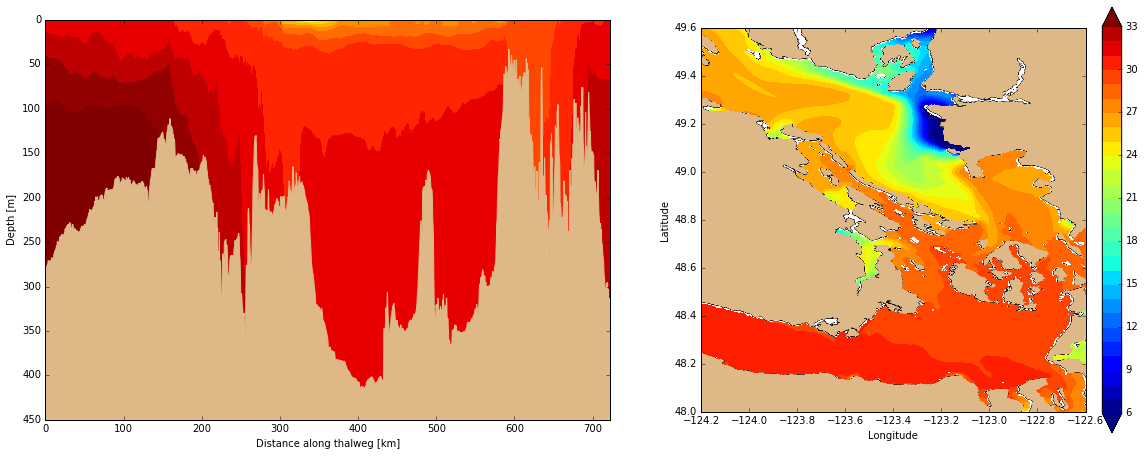

In [9]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')


grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

nowcast = '/results/SalishSea/nowcast/'
date = datetime.datetime(2016, 4, 4)
grid_T = results_dataset(nowcast, date, '1d', 'grid_T')

var = grid_T.variables['vosaline'][0,:,:,:]

a = tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask)
plt.show(a)